## Example 07 - Using actual graphs and graph_module.py

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime
import platform
import random
import os

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style
from osgeo import ogr, osr

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSIM
import opentnsim.core as core
import opentnsim.graph_module as graph_module

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx  

# Graph location
location_graph = "Shape-Files/Vaarwegvakken"
name_graph = "Vaarwegvakken.shp"
name_graph_conv = "Vaarwegvakken - wgs84.shp"

### Create graph

The cel below visualizes the problem. In graph theory the red dots are called *edges* and the lines are called *vertices*. Vessels (or any other object) move from edge 1 to edge 3 and from edge 4 to edge 2. The added complexity is that vertice 5-6 only allows traffic in one direction at a time. Vessels can travel simultanously in one direction.

**Important**: 

If you use windows and get the following error "ImportError: read_shp requires OGR: http://www.gdal.org/", you probably have [this issue](https://github.com/conda-forge/gdal-feedstock/issues/219). Solving it is possible by running the following commands in your terminal (as explained [here](https://gis.stackexchange.com/questions/294231/installing-gdal-with-anaconda):

```bash
#Create a new virtual environment
conda create -n testgdal -c conda-forge gdal vs2015_runtime=14

#Activate virtual environment
activate testgdal

#Open Jupyter notebook
jupyer notebook
```

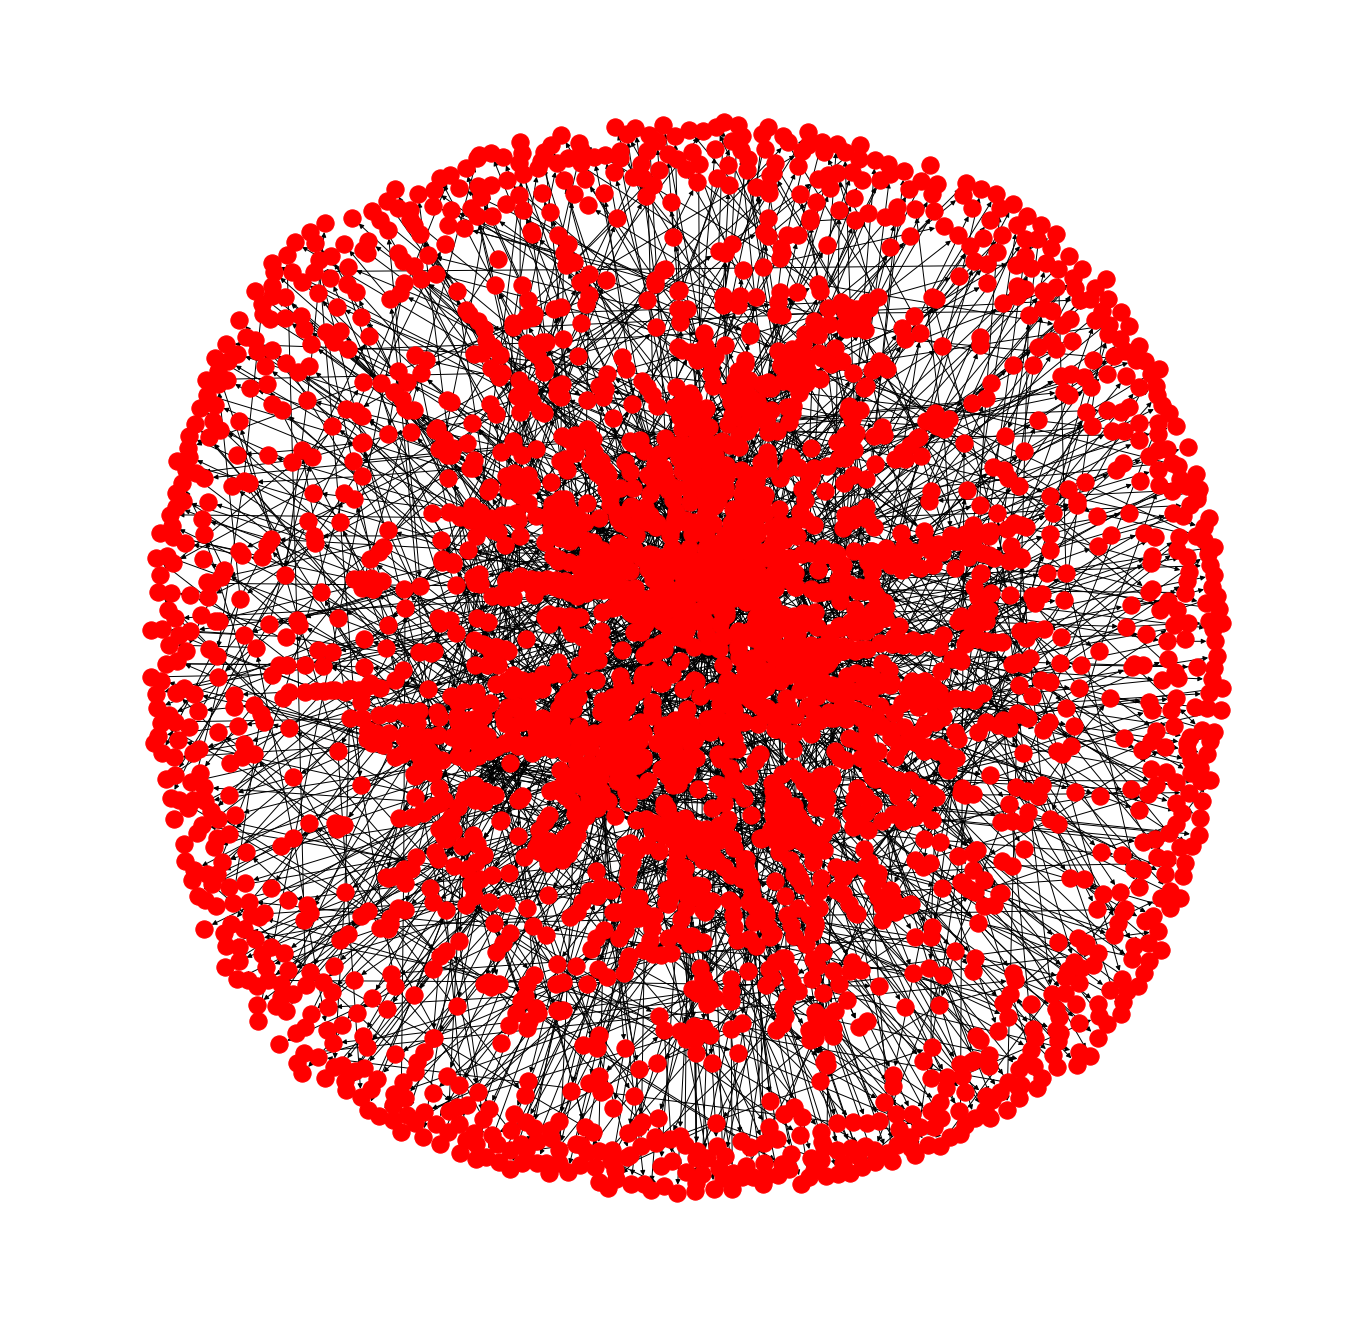

In [2]:
# Read the shape-file
FG = nx.read_shp(os.path.join(location_graph, name_graph), 
                 simplify=True)

# Draw the shape-file to get a first impression
plt.figure(figsize=(18,18))
nx.draw(FG)

# Show the drawing
plt.show()

### Convert to WGS84

In [3]:
def transform_projection(location_graph, name_graph):
    driver = ogr.GetDriverByName('ESRI Shapefile')
    dataset = driver.Open(os.path.join(location_graph, name_graph))

    # from Layer
    inSpatialRef = dataset.GetLayer().GetSpatialRef()

    # Set up the coordinate reference we want to use, WGS84 - World Geodetic System 1984
    outSpatialRef = osr.SpatialReference()
    outSpatialRef.ImportFromEPSG(4326)

    # Transform the coordinates
    transform = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)
    
    return transform

In [4]:
def change_projection(transform, point):
    point = ogr.CreateGeometryFromWkt(str(point))
    
    point.Transform(transform)
    point.ExportToWkt()
    
    return point.GetX(), point.GetY()

In [5]:
transform = transform_projection(location_graph, name_graph)
FG_test = nx.DiGraph()

nodes_dict = {}

for i, node in enumerate(FG.nodes(data = True)):
    coordinates = change_projection(transform, shapely.geometry.Point(list(FG.nodes)[i][0], list(FG.nodes)[i][1]))
    name = "({:f}, {:f})".format(coordinates[0], coordinates[1])
    geometry = shapely.geometry.Point(coordinates[0], coordinates[1])
    
    nodes_dict[list(FG.nodes)[i]] = name
    FG_test.add_node(name, Name = name, Position = coordinates, Geometry = geometry, Old = node[1])
    
for edge in FG.edges(data = True):
    node_1 = nodes_dict[edge[0]]
    node_2 = nodes_dict[edge[1]]
    
    FG_test.add_edge(node_1, node_2, Info = edge[2])

if nx.info(FG) == nx.info(FG_test):
    print("Succes!")

Succes!


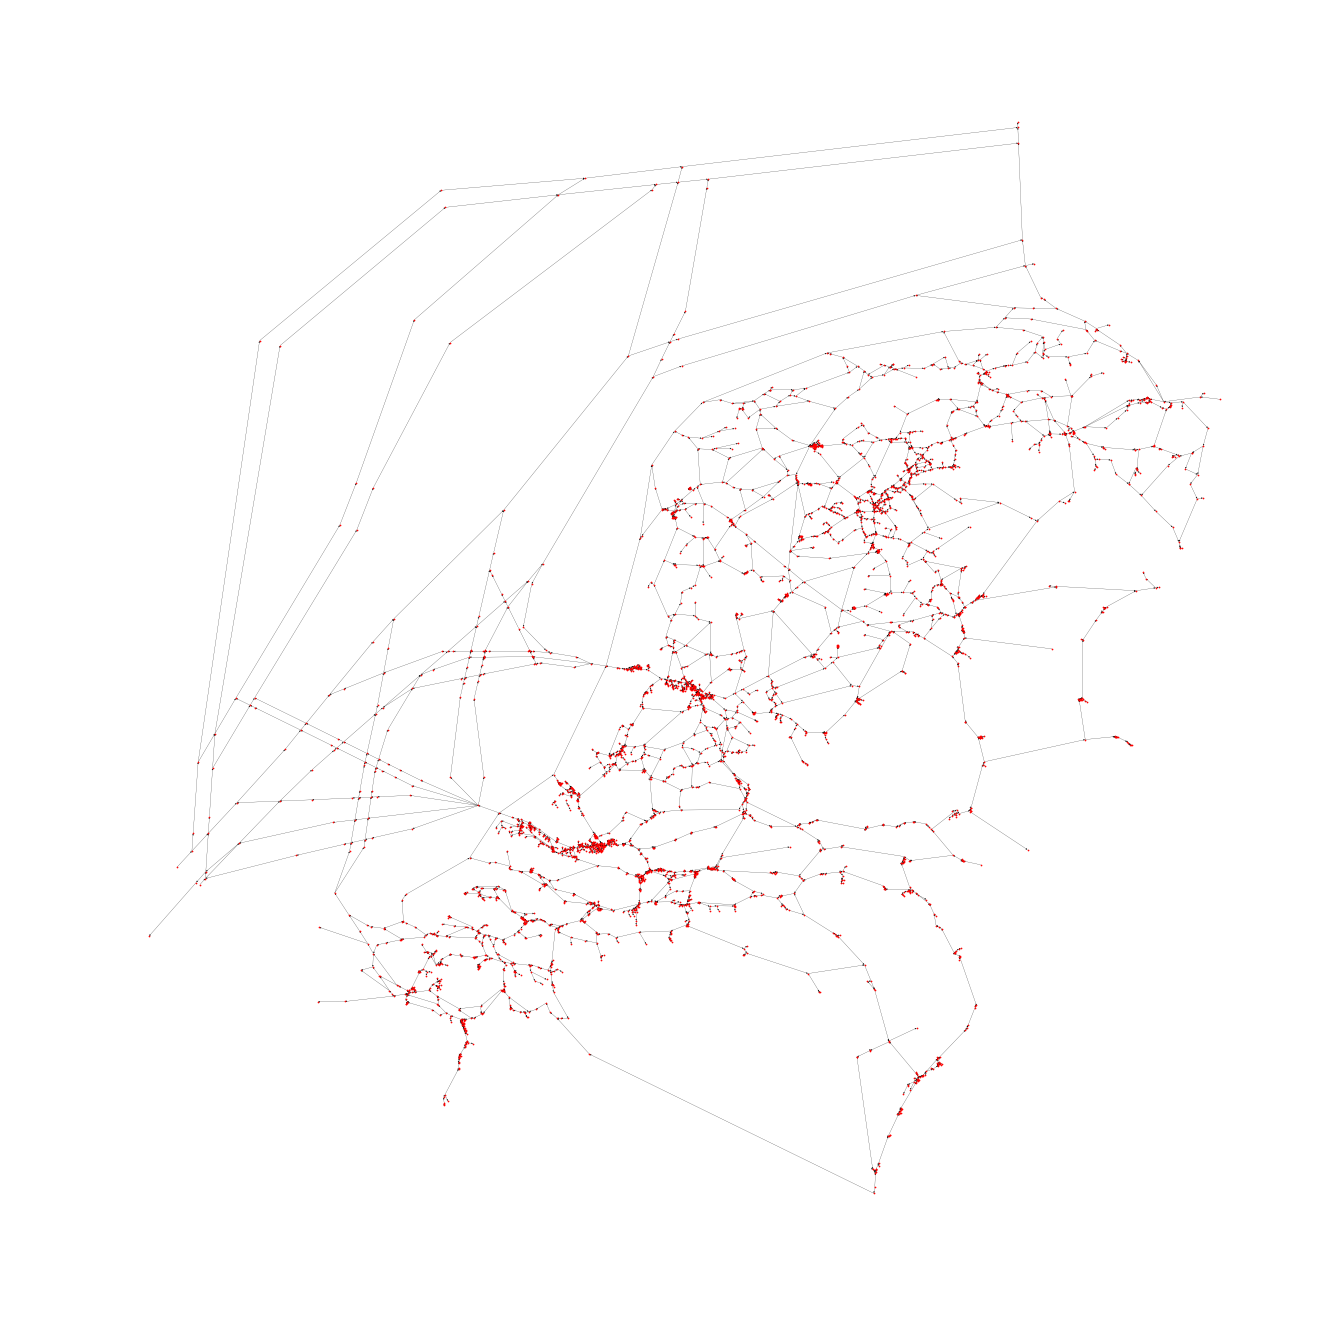

In [6]:
plt.figure(figsize=(18,18))
nx.draw(FG_test, nx.get_node_attributes(FG_test, 'Position'), node_size=0.5, font_size = 2, width = 0.2, arrowsize = 3)
plt.show()

In [7]:
for i, node in enumerate(FG_test.nodes(data = True)):
    print(node)
    
    if i > 0:
        break

('(3.706415, 51.522951)', {'Name': '(3.706415, 51.522951)', 'Position': (3.7064154075981963, 51.52295100191865), 'Geometry': <shapely.geometry.point.Point object at 0x0000022AC59534A8>, 'Old': {}})
('(3.698245, 51.520999)', {'Name': '(3.698245, 51.520999)', 'Position': (3.69824452576935, 51.520999110014486), 'Geometry': <shapely.geometry.point.Point object at 0x0000022AC5953438>, 'Old': {}})


In [8]:
for i, edge in enumerate(FG_test.edges(data = True)):
    print(edge)
    
    if i > 0:
        break

('(3.706415, 51.522951)', '(3.698245, 51.520999)', {'Info': {'VWK_ID': 2069, 'VWK_BEGDTM': '1998/01/01', 'VWJ_ID_BEG': 1721, 'VWJ_ID_END': 1708, 'VAKTYPE': 'D', 'VRT_CODE': '135', 'VRT_NAAM': 'Zandkreek en Veerse Meer', 'VWG_NR': 1, 'VWG_NAAM': 'Veerse Meer', 'BEGKM': 17.856, 'ENDKM': 18.483, 'ShpName': 'Vaarwegvakken', 'Wkb': b'\x00\x00\x00\x00\x02\x00\x00\x00\x06@\xe2\xba\xc0\x00\x00\x00\x00A\x18\x0c\\\x00\x00\x00\x00@\xe2\x9c\x80\x00\x00\x00\x00A\x18\n\x10\x00\x00\x00\x00@\xe2\x95\x00\x00\x00\x00\x00A\x18\tx\x00\x00\x00\x00@\xe2\x8a\xe0\x00\x00\x00\x00A\x18\t0\x00\x00\x00\x00@\xe2x\x80\x00\x00\x00\x00A\x18\t\x14\x00\x00\x00\x00@\xe2s@\x00\x00\x00\x00A\x18\t,\x00\x00\x00\x00', 'Wkt': 'LINESTRING (38358 394007,38116 393860,38056 393822,37975 393804,37828 393797,37786 393803)', 'Json': '{ "type": "LineString", "coordinates": [ [ 38358.0, 394007.0 ], [ 38116.0, 393860.0 ], [ 38056.0, 393822.0 ], [ 37975.0, 393804.0 ], [ 37828.0, 393797.0 ], [ 37786.0, 393803.0 ] ] }'}})
('(3.698245, 51.

### Using graph module

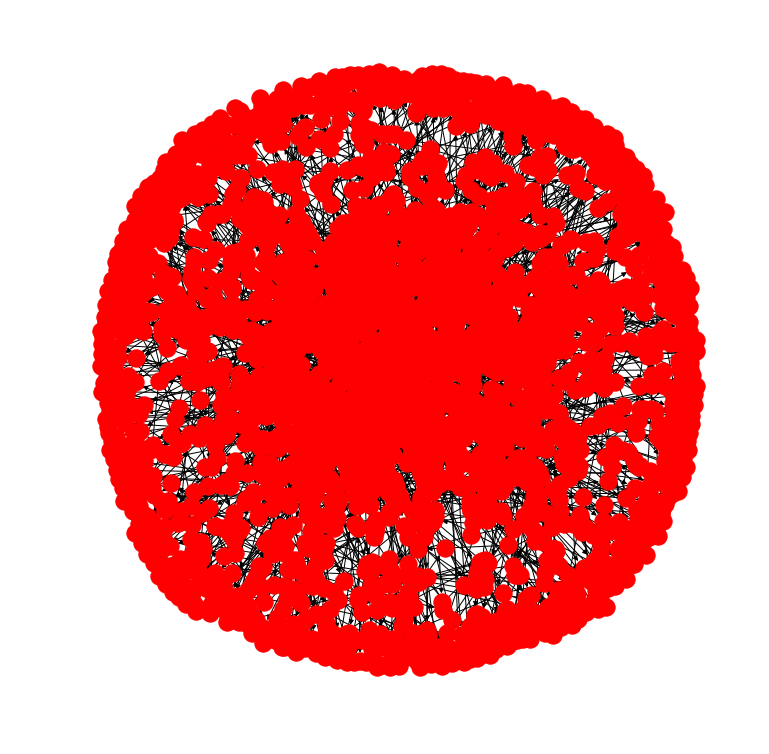

In [9]:
graph = graph_module.Graph()
graph.from_shape(location_graph, name_graph)
graph.plot()

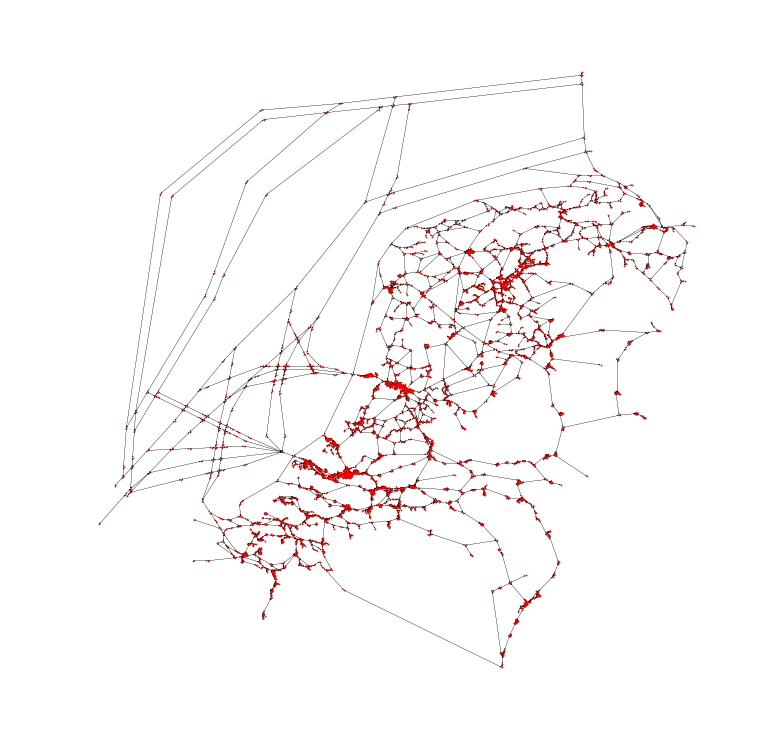

In [10]:
graph.create_graph_new_projection()
graph.plot()

In [11]:
for i, node in enumerate(graph.graph.nodes(data = True)):
    print(node)
    
    if i > 0:
        break

('(3.706415, 51.522951)', {'name': '(3.706415, 51.522951)', 'Position': (3.7064154075981963, 51.52295100191865), 'geometry': <shapely.geometry.point.Point object at 0x0000022AC9665B70>, 'Old': {}})
('(3.698245, 51.520999)', {'name': '(3.698245, 51.520999)', 'Position': (3.69824452576935, 51.520999110014486), 'geometry': <shapely.geometry.point.Point object at 0x0000022ACA98DBE0>, 'Old': {}})


In [12]:
for i, edge in enumerate(graph.graph.edges(data = True)):
    print(edge)
    
    if i > 0:
        break

('(3.706415, 51.522951)', '(3.698245, 51.520999)', {'Info': {'VWK_ID': 2069, 'VWK_BEGDTM': '1998/01/01', 'VWJ_ID_BEG': 1721, 'VWJ_ID_END': 1708, 'VAKTYPE': 'D', 'VRT_CODE': '135', 'VRT_NAAM': 'Zandkreek en Veerse Meer', 'VWG_NR': 1, 'VWG_NAAM': 'Veerse Meer', 'BEGKM': 17.856, 'ENDKM': 18.483, 'ShpName': 'Vaarwegvakken', 'Wkb': b'\x00\x00\x00\x00\x02\x00\x00\x00\x06@\xe2\xba\xc0\x00\x00\x00\x00A\x18\x0c\\\x00\x00\x00\x00@\xe2\x9c\x80\x00\x00\x00\x00A\x18\n\x10\x00\x00\x00\x00@\xe2\x95\x00\x00\x00\x00\x00A\x18\tx\x00\x00\x00\x00@\xe2\x8a\xe0\x00\x00\x00\x00A\x18\t0\x00\x00\x00\x00@\xe2x\x80\x00\x00\x00\x00A\x18\t\x14\x00\x00\x00\x00@\xe2s@\x00\x00\x00\x00A\x18\t,\x00\x00\x00\x00', 'Wkt': 'LINESTRING (38358 394007,38116 393860,38056 393822,37975 393804,37828 393797,37786 393803)', 'Json': '{ "type": "LineString", "coordinates": [ [ 38358.0, 394007.0 ], [ 38116.0, 393860.0 ], [ 38056.0, 393822.0 ], [ 37975.0, 393804.0 ], [ 37828.0, 393797.0 ], [ 37786.0, 393803.0 ] ] }'}})
('(3.706415, 51.

### Select specific area
If we were to only be interested in the Rotterdam - Antwerp part of the graph, we should be able to define a graph as a subset of the original. We define a square in which we are interested in the information, any node outside of this square is omitted from further analysis.

    North-East point: 4.85, 52.00
    South-East point: 4.85, 51.00
    South-West point: 2.75, 51.00
    North-West point: 2.75, 52.00

In [13]:
area = shapely.geometry.Polygon(((4.85, 52), (4.85, 51), (2.75, 51), (2.75, 52)))

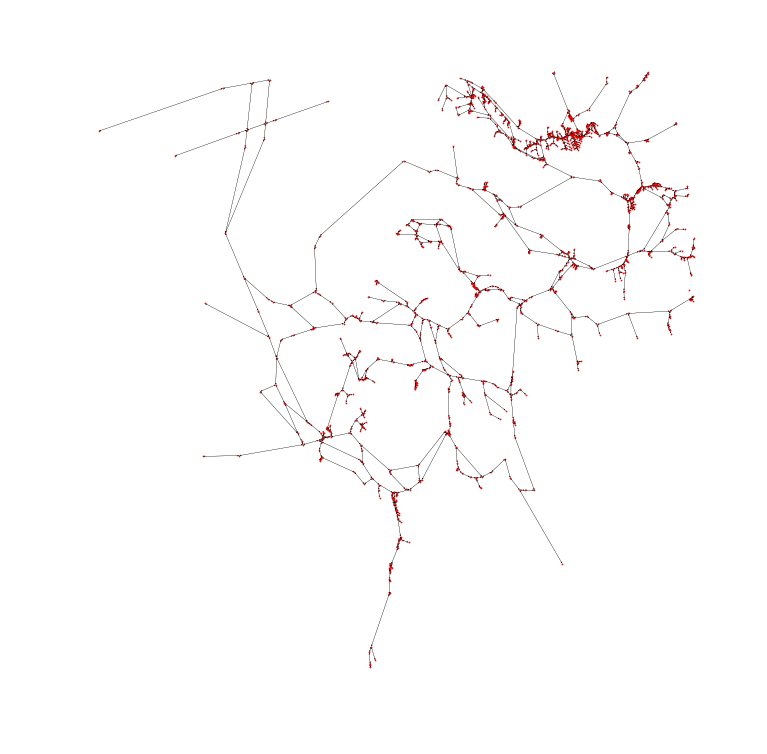

In [14]:
to_remove = []

for node in graph.graph.nodes(data = True):
    if node[1]["geometry"].within(area):
        continue
    
    else:
        to_remove.append(node[0])

graph.graph.remove_nodes_from(to_remove)
graph.plot()

### Print graph on actual map

In [15]:
from simplekml import Kml, Style
kml = Kml()
fol = kml.newfolder(name="Vessels")

shared_style = Style()
shared_style.labelstyle.color = 'ffffffff'  # White
shared_style.labelstyle.scale = 1  
shared_style.iconstyle.color = 'ffffffff'  # White
shared_style.iconstyle.scale = 1
shared_style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/donut.png'
shared_style.linestyle.color = 'ff0055ff'  # Red
shared_style.linestyle.width = 5

nodes = list(graph.graph.nodes)

# each timestep will be represented as a single point
for log_index, value in enumerate(list(graph.graph.nodes)[0:-1-1]):

    pnt = fol.newpoint(name='', 
                       coords=[(nx.get_node_attributes(graph.graph, "geometry")[nodes[log_index]].x,
                                nx.get_node_attributes(graph.graph, "geometry")[nodes[log_index]].y)])
    pnt.style = shared_style

edges = list(graph.graph.edges)
for log_index, value in enumerate(list(graph.graph.edges)[0:-1-1]):

    lne = fol.newlinestring(name='',
                            coords = [(nx.get_node_attributes(graph.graph, "geometry")[edges[log_index][0]].x,
                                       nx.get_node_attributes(graph.graph, "geometry")[edges[log_index][0]].y),
                                      (nx.get_node_attributes(graph.graph, "geometry")[edges[log_index][1]].x,
                                       nx.get_node_attributes(graph.graph, "geometry")[edges[log_index][1]].y)])
    lne.style = shared_style

kml.save("Example 07 - Graph.kml")